[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/hybrid-search/ecommerce-search/ecommerce-search.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/hybrid-search/ecommerce-search/ecommerce-search.ipynb)

# Hybrid Search for E-Commerce with Pinecone


Hybrid vector search is combination of traditional keyword search and modern dense vector search. It has emerged as a powerful tool for e-commerce companies looking to improve the search experience for their customers.

By combining the strengths of traditional text-based search algorithms with the visual recognition capabilities of deep learning models, hybrid vector search allows users to search for products using a combination of text and images. This can be especially useful for product searches, where customers may not know the exact name or details of the item they are looking for.

Pinecone's new **sparse-dense index** allows you to seamlessly perform hybrid search for e-commerce or in any other context. This notebook demonstrates how to use the new hybrid search feature to improve e-commerce search.

## Install Dependencies

First, let's import the necessary libraries


In [137]:
!pip install -qU datasets transformers sentence-transformers \
                 pinecone-client pinecone-text protobuf==3.20.3


You should consider upgrading via the 'C:\Users\91887\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [138]:
!pip install pandas requests Pillow datasets


You should consider upgrading via the 'C:\Users\91887\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## Connect to Pinecone

Let's initiate a connection and create an index. For this, we need a [free API key](https://app.pinecone.io/), and then we initialize the connection like so:

In [139]:
import os
import pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.getenv("PINECONE_API_KEY") or "fc0e7d98-b575-4842-9af2-619419ed1f50"
# find your environment next to the api key in pinecone console
env = os.getenv("PINECONE_ENVIRONMENT") or "gcp-starter"

# init connection to pinecone
pinecone.init(
    api_key=api_key,
    environment=env
)

To use the `sparse-dense` index in Pinecone we must set `metric="dotproduct"` and use either `s1` or `p1` pods. We also align the `dimension` value to that of our retrieval model, which outputs `512`-dimensional vectors.

In [140]:
# choose a name for your index
index_name = "grid-database"

if index_name not in pinecone.list_indexes():
    # create the index
    pinecone.create_index(
      index_name,
      dimension=512,
      metric="dotproduct",
      pod_type="s1"
    )

Now we have created the sparse-dense enabled index, we connect to it:

In [141]:
pinecone_index = pinecone.Index(index_name)

*Note: we are using `GRPCIndex` rather than `Index` for the improved upsert speeds, either can be used with the sparse-dense index.*

# Load Dataset

We will work with a subset of the [Open Fashion Product Images](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small) dataset, consisting of ~44K fashion products with images and category labels describing the products. The dataset can be loaded from the Huggigface Datasets hub as follows:

In [142]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from datasets import Dataset

# Load CSV data into a Pandas DataFrame
csv_path = "./Current-Data1.csv"
data = pd.read_csv(csv_path,encoding='utf-8')

# Display the first few rows of the DataFrame
# data

# print(len(data))

# from datasets import load_dataset

# # load the dataset from huggingface datasets hub
# fashion = load_dataset(
#     "ashraq/fashion-product-images-small",
#     split="train"
# )
# fashion


# from datasets import load_dataset

# # load the dataset from huggingface datasets hub
# fashion = load_dataset("csv", data_files="/content/sample_data/Training_Pinecone.csv", delimiter="\t", column_names=["id","gender","masterCategory","subCategory","articleType","baseColour","season","year","usage","productDisplayName","link"], split="train", )
# fashion

We will first assign the images and metadata into separate variables and then convert the metadata into a pandas dataframe.

In [143]:
metadata = data.drop(columns=['year'])
# Convert metadata to a Pandas DataFrame
# metadata = metadata.to_pandas()

# Initialize empty list to store images
images = []

# Loop through each row in the DataFrame
for index, row in data.iterrows():
    # Download image from the 'link' column
    image_url = row['link']
    response = requests.get(image_url)
    if response.status_code == 200:
        # Convert the downloaded content into a PIL image
        img = Image.open(BytesIO(response.content))
        images.append(img)
    else:
        print(f"Failed to download image for index {index}")

# Now you can work directly with 'metadata' Pandas DataFrame and 'images' list
# For example:
# print(metadata.head())
# for column in metadata.columns:
#     if metadata[column].dtype == 'object':
#         try:
#             pd.to_numeric(metadata[column], errors='raise')
#             print(f"{column} might contain numeric data (including floats).")
#         except:
#             print(f"{column} likely contains non-numeric data (including strings).")
#     else:
#         print(f"{column} has data type {metadata[column].dtype}.")


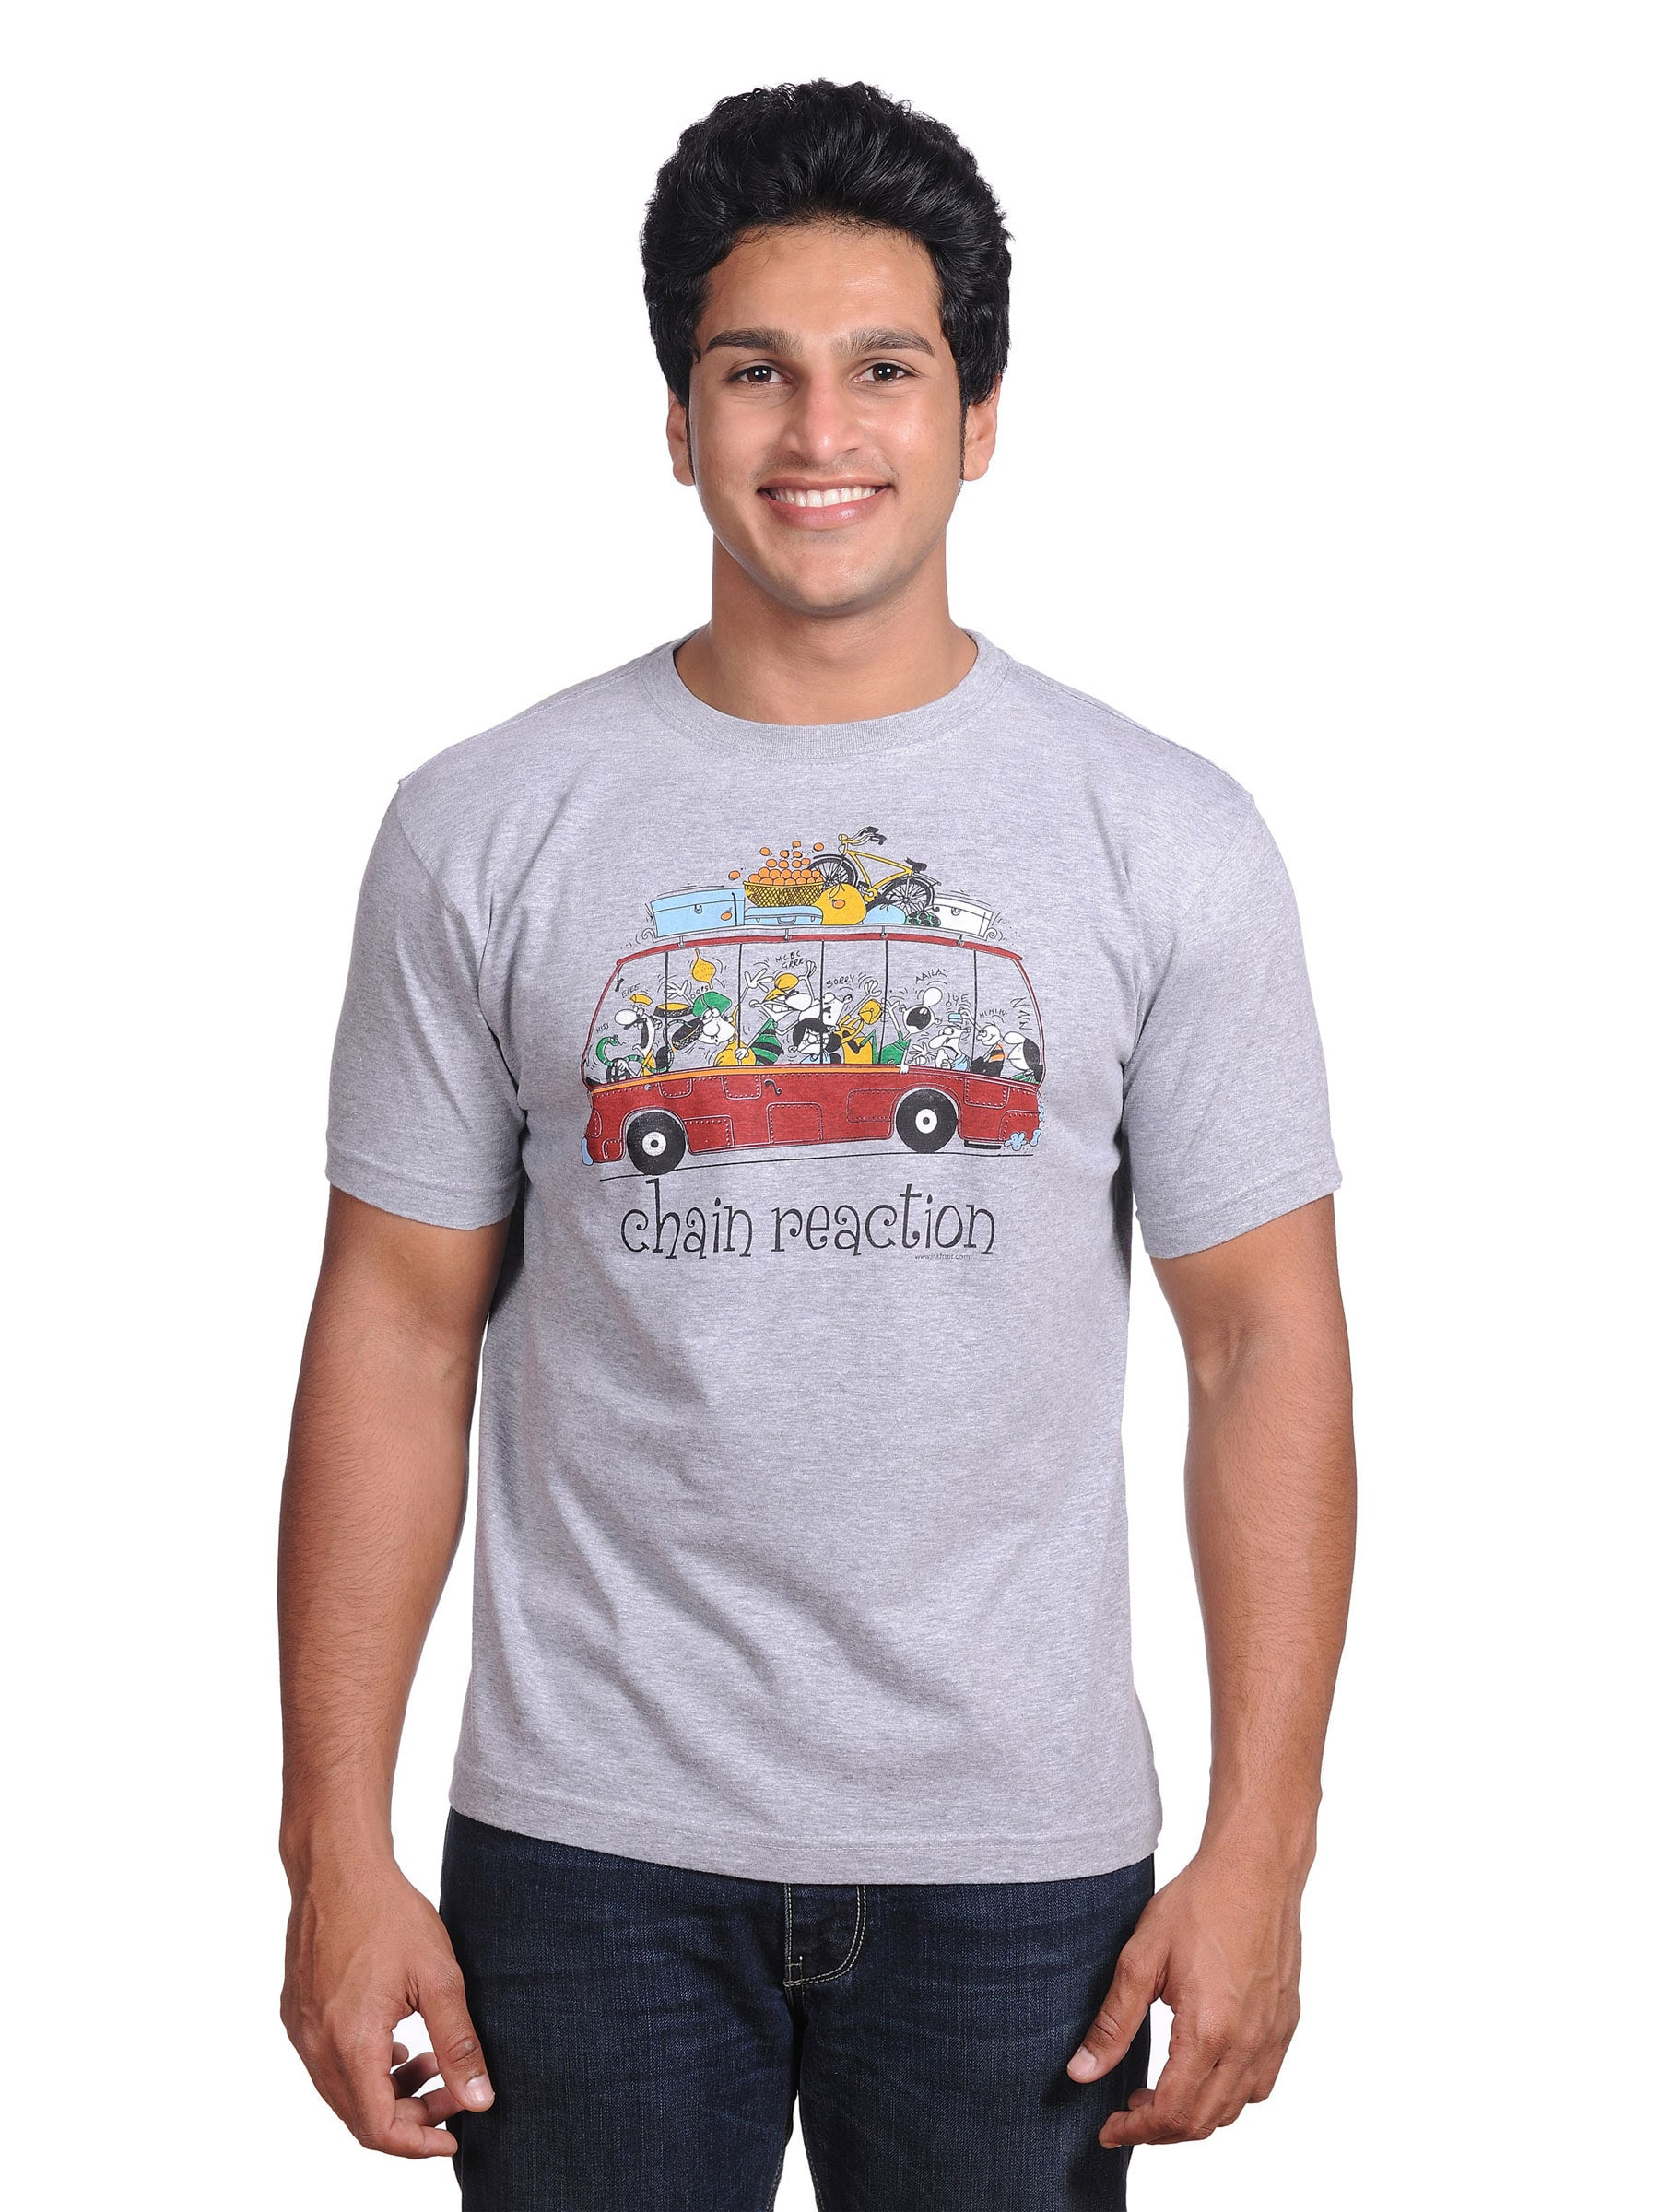

In [144]:
images[5]

We need both sparse and dense vectors to perform hybrid search. We will use all the metadata fields except for the `id` and `year` to create sparse vectors and the product images to create dense vectors.

## Sparse Vectors

To create the sparse vectors we'll use BM25. We import the BM25 function from the [`pinecone-text` library](https://github.com/pinecone-io/pinecone-text).

In [145]:
from pinecone_text.sparse import BM25Encoder

bm25 = BM25Encoder()

The tokenization will look something like this:

In [146]:
"Turtle Check Men Navy Blue Shirt".lower().split()

['turtle', 'check', 'men', 'navy', 'blue', 'shirt']

BM25 requires training on a representative portion of the dataset. We do this like so:

In [147]:
bm25.fit(metadata['productDisplayName'])

100%|██████████| 99/99 [00:00<00:00, 2464.63it/s]


Let's create a test sparse vector using a `productDisplayName`.

In [148]:
metadata['productDisplayName'][0]

'Turtle Check Men Navy Blue Shirt'

In [149]:
bm25.encode_queries(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.2594246685304943,
  0.22786988892933388,
  0.03526752616074417,
  0.19156106298057124,
  0.13360216218388135,
  0.15227469121497506]}

And for the stored docs, we only need the "IDF" part:

In [150]:
bm25.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.44386422976501305,
  0.44386422976501305,
  0.44386422976501305,
  0.44386422976501305,
  0.44386422976501305,
  0.44386422976501305]}

## Dense Vectors

We will use the CLIP to generate dense vectors for product images. We can directly pass PIL images to CLIP as it can encode both images and texts. We can load CLIP like so:

## Images is an array of PIL objects (Dense Vectors are made on it)
## Metadata is a pandas datafram object (Sparse Vectors are made on it)
## 

In [151]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model

SentenceTransformer(
  (0): CLIPModel()
)

In [152]:
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

(1, 512)

The model gives us a `512` dimensional dense vector.

## Upsert Documents

Now we can go ahead and generate sparse and dense vectors for the full dataset and upsert them along with the metadata to the new hybrid index. We can do that easily as follows:

In [153]:
from tqdm.auto import tqdm
# print(type(pinecone_index))
batch_size = 200
# len(data)
for i in tqdm(range(0, len(data), batch_size)):
    # find end of batch
    
    i_end = min(i+batch_size, len(data))
    # extract metadata batch
    print('ending varaible', i_end)
   
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
  
    print('the dict is this\n', meta_dict)
    print('length of the dict\n', len(meta_dict))
    # concatinate all metadata field except for id and year to form a single string
    # meta_batch_text = [" ".join(row) for row in meta_batch.values.tolist()]
    # meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'link'])].values.tolist()]


    # Convert all columns (except 'id' and 'link') to strings
    meta_batch = meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'link'])].astype(str)

    # Join the values in each row into a single string
    meta_batch_strings = [" ".join(row) for row in meta_batch.values.tolist()]
    # print('the string which is being uploaded to pinecone for sparse vector \n', meta_batch_strings);
    # # meta_batch_text = [" ".join(str(value) for value in row) for row in meta_batch.values.tolist()]
    # # extract image batch
    # print('meta dictionary \n', meta_dict)
    # for x in meta_dict:
    #     print(str(x["id"]))
    #     print(type(str(x["id"])))
        


    img_batch = images[i:i_end]
    print('the dense is this\n', len(images))
    
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch_strings])
    print('the sparse is this\n', len(sparse_embeds))
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    print('the dense is this\n', len(dense_embeds))
    
    # create unique IDs
    # ids = [str(x) for x in range(i, i_end)]
    # for x in ids:
    #     print(ids[int(x)])

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for sparse, dense, meta in zip(sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': str(meta["id"]),
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    print('length of upserts: \n', len(upserts))
    pinecone_index.upsert(upserts)
    # print(index)
    # print(type(pinecone_index))


# show index description after uploading the documents
pinecone_index.describe_index_stats()

# Error I am getting is AttributeError: 'int' object has no attribute 'describe_index_stats' 
# which could mean is that the index we are having does not have int object into which we can upsert to 


  0%|          | 0/1 [00:00<?, ?it/s]

ending varaible 99
the dict is this
 [{'id': 15970, 'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Topwear', 'articleType': 'Shirts', 'baseColour': 'Navy Blue', 'season': 'Fall', 'usage': 'Casual', 'productDisplayName': 'Turtle Check Men Navy Blue Shirt', 'link': 'http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg'}, {'id': 39386, 'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Bottomwear', 'articleType': 'Jeans', 'baseColour': 'Blue', 'season': 'Summer', 'usage': 'Casual', 'productDisplayName': 'Peter England Men Party Blue Jeans', 'link': 'http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg'}, {'id': 59263, 'gender': 'Women', 'masterCategory': 'Accessories', 'subCategory': 'Watches', 'articleType': 'Watches', 'baseColour': 'Silver', 'season': 'Winter', 'usage': 'Casual', 'productDisplayName': 'Titan Women Silver Watch', 'link': 'http://assets.myntassets.com/v1

100%|██████████| 1/1 [00:34<00:00, 34.01s/it]


{'dimension': 512,
 'index_fullness': 8e-05,
 'namespaces': {'': {'vector_count': 8}},
 'total_vector_count': 8}

Following is the upserting done via multithreading


In [154]:
# from concurrent.futures import ThreadPoolExecutor
# from tqdm.auto import tqdm

# batch_size = 200

# def process_batch(start_idx, end_idx):
#     meta_batch = metadata.iloc[start_idx:end_idx]
#     meta_dict = meta_batch.to_dict(orient="records")
#     # meta_batch_text = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
#     meta_batch_text = [" ".join(str(value) for value in row) for row in meta_batch.values.tolist()]
#     img_batch = images[start_idx:end_idx]
    
#     sparse_embeds = bm25.encode_documents(meta_batch_text)
#     dense_embeds = model.encode(img_batch).tolist()
    
#     ids = [str(x) for x in range(start_idx, end_idx)]
    
#     upserts = []
#     for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
#         upserts.append({
#             'id': _id,
#             'sparse_values': sparse,
#             'values': dense,
#             'metadata': meta
#         })
#     index.upsert(upserts)

# total_records = len(data)

# with ThreadPoolExecutor() as executor:
#     futures = []
#     for i in tqdm(range(0, total_records, batch_size)):
#         i_end = min(i + batch_size, total_records)
#         future = executor.submit(process_batch, i, i_end)
#         futures.append(future)
    
#     # Wait for all futures to complete
#     for future in futures:
#         future.result()

# index.describe_index_stats()


## Querying

Now we can query the index, providing the sparse and dense vectors. We do this directly with an equal weighting between sparse and dense like so:

In [155]:
# query = "Girls	Apparel	Topwear	Tops White Summer	Casual	Gini and Jony Girls Knit White Top"

# # create sparse and dense vectors

# # search
# result = pinecone_index.query(
#     top_k=14,
#     vector=dense,
#     sparse_vector=sparse,
#     include_metadata=True
# )
# # used returned product ids to get images
# print(result["matches"])
# # for r in result["matches"]:
# #     print(r["id"])

# # a= (int(r["id"]) for r in result["matches"])
# # print(type(a))
# # imgs = [images[int(r["id"])] for r in result["matches"]]
# # imgs

We return a list of PIL image objects, to view them we will define a function called `display_result`.

In [156]:
# from IPython.core.display import HTML
# from io import BytesIO
# from base64 import b64encode

# # function to display product images
# def display_result(image_batch):
#     figures = []
#     for img in image_batch:
#         b = BytesIO()  
#         img.save(b, format='png')
#         figures.append(f'''
#             <figure style="margin: 5px !important;">
#               <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
#             </figure>
#         ''')
#     return HTML(data=f'''
#         <div style="display: flex; flex-flow: row wrap; text-align: center;">
#         {''.join(figures)}
#         </div>
#     ''')

And now we can view them:

In [157]:
# display_result(imgs)

It's possible to prioritize our search based on sparse vs. dense vector results. To do so, we scale the vectors, for this we'll use a function named `hybrid_scale`.

In [158]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

First, we will do a pure sparse vector search by setting the alpha value as 0.

In [177]:
query = "Peter England baby blue jeans for men"
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = pinecone_index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
print(result["matches"])
# used returned product ids to get images
# imgs = [images[int(r["id"])] for r in result["matches"]]
# # display the images
# display_result(imgs)

[{'id': '39386',
 'metadata': {'articleType': 'Jeans',
              'baseColour': 'Blue',
              'gender': 'Men',
              'id': 39386.0,
              'link': 'http://assets.myntassets.com/v1/images/style/properties/4850873d0c417e6480a26059f83aac29_images.jpg',
              'masterCategory': 'Apparel',
              'productDisplayName': 'Peter England Men Party Blue Jeans',
              'season': 'Summer',
              'subCategory': 'Bottomwear',
              'usage': 'Casual'},
 'score': 1.57213,
 'values': []}, {'id': '7990',
 'metadata': {'articleType': 'Tshirts',
              'baseColour': 'Navy Blue',
              'gender': 'Men',
              'id': 7990.0,
              'link': 'http://assets.myntassets.com/v1/images/style/properties/296a8c388d05d67346db88af27d3b763_images.jpg',
              'masterCategory': 'Apparel',
              'productDisplayName': "Fila Men's Round Neck Navy Blue T-shirt",
              'season': 'Fall',
              'subCategory'

Let's take a look at the description of the result.

In [176]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Gini and Jony Girls Knit White Top
Mineral Women Green Top
Tonga Women Maroon Top
SDL by Sweet Dreams Women Green Printed Night Suit S11-3124
Rocky S Women White Handbag
Bwitch Beige Full-Coverage Bra BW335
Gini and Jony Boy's Kaleb White Brown Kidswear
Levis Men Comfort Style Grey Innerwear Vest
Vishudh Women Brown Kurta
Jealous 21 Women's Pink T-shirt
Jealous 21 Women Purple Shirt
W Women Printed Beige Kurta
Diva Women Embroided Green Kurta
Nike Women Purple Polo T-shirt


We can observe that the keyword search returned French Connection jeans but failed to rank the men's French Connection jeans higher than a few of the women's. Now let's do a pure semantic image search by setting the alpha value to 1.

In [161]:
# # scale sparse and dense vectors
# hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# # search
# result = index.query(
#     top_k=14,
#     vector=hdense,
#     sparse_vector=hsparse,
#     include_metadata=True
# )
# # used returned product ids to get images
# imgs = [images[int(r["id"])] for r in result["matches"]]
# # display the images
# display_result(imgs)

In [162]:
# for x in result["matches"]:
#     print(x["metadata"]['productDisplayName'])

The semantic image search correctly returned blue jeans for men, but mostly failed to match the exact brand we are looking for — French Connection. Now let's set the alpha value to `0.05` to try a hybrid search that is slightly more dense than sparse search.

In [163]:
# # scale sparse and dense vectors
# hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# # search
# result = index.query(
#     top_k=14,
#     vector=hdense,
#     sparse_vector=hsparse,
#     include_metadata=True
# )
# # used returned product ids to get images
# imgs = [images[int(r["id"])] for r in result["matches"]]
# # display the images
# display_result(imgs)

In [164]:
# for x in result["matches"]:
#     print(x["metadata"]['productDisplayName'])

By performing a mostly sparse search with some help from our image-based dense vectors, we get a strong number of French Connection jeans, that are for men, and visually are almost all aligned to blue jeans.

Let's try more queries.

In [165]:
# query = "small beige handbag for women"
# # create sparse and dense vectors
# sparse = bm25.encode_queries(query)
# dense = model.encode(query).tolist()
# # scale sparse and dense vectors - keyword search first
# hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# # search
# result = index.query(
#     top_k=14,
#     vector=hdense,
#     sparse_vector=hsparse,
#     include_metadata=True
# )
# # used returned product ids to get images
# imgs = [images[int(r["id"])] for r in result["matches"]]
# # display the images
# display_result(imgs)

We get a lot of small handbags for women, but they're not beige. Let's use the image dense vectors to weigh the colors higher.

In [166]:
# # scale sparse and dense vectors
# hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# # search
# result = index.query(
#     top_k=14,
#     vector=hdense,
#     sparse_vector=hsparse,
#     include_metadata=True
# )
# # used returned product ids to get images
# imgs = [images[int(r["id"])] for r in result["matches"]]
# # display the images
# display_result(imgs)

In [167]:
# for x in result["matches"]:
#     print(x["metadata"]['productDisplayName'])

Here we see better aligned handbags.

In [168]:
# # scale sparse and dense vectors
# hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# # search
# result = index.query(
#     top_k=14,
#     vector=hdense,
#     sparse_vector=hsparse,
#     include_metadata=True
# )
# # used returned product ids to get images
# imgs = [images[int(r["id"])] for r in result["matches"]]
# # display the images
# display_result(imgs)

If we go too far with dense vectors, we start to see a few purses, rather than handbags.

Let's run some more interesting queries. This time we will use a **product image** to create our dense vector, we'll provide a text query as before that will be used to create the sparse vector, and then we'll select a specific color as per the metadata attached to each image, with [metadata filtering](https://docs.pinecone.io/docs/metadata-filtering).

In [169]:
# images[36254]

In [170]:
# query = "soft purple topwear"
# # create the sparse vector
# sparse = bm25.encode_queries(query)
# # now create the dense vector using the image
# dense = model.encode(images[36254]).tolist()
# # scale sparse and dense vectors
# hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# # search
# result = index.query(
#     top_k=14,
#     vector=hdense,
#     sparse_vector=hsparse,
#     include_metadata=True
# )
# # use returned product ids to get images
# imgs = [images[int(r["id"])] for r in result["matches"]]
# # display the images
# display_result(imgs)

Our "purple" component isn't being considered strongly enough, let's add this to the metadata filtering:

In [171]:
# query = "soft purple topwear"
# # create the sparse vector
# sparse = bm25.encode_queries(query)
# # now create the dense vector using the image
# dense = model.encode(images[36254]).tolist()
# # scale sparse and dense vectors
# hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# # search
# result = index.query(
#     top_k=14,
#     vector=hdense,
#     sparse_vector=hsparse,
#     include_metadata=True,
#     filter={"baseColour": "Purple"}  # add to metadata filter
# )
# # used returned product ids to get images
# imgs = [images[int(r["id"])] for r in result["matches"]]
# # display the images
# display_result(imgs)

Let's try with another image:

In [172]:
# images[36256]

In [173]:
# query = "soft green color topwear"
# # create the sparse vector
# sparse = bm25.encode_queries(query)
# # now create the dense vector using the image
# dense = model.encode(images[36256]).tolist()
# # scale sparse and dense vectors
# hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.6)
# # search
# result = index.query(
#     top_k=14,
#     vector=hdense,
#     sparse_vector=hsparse,
#     include_metadata=True,
#     filter={"baseColour": "Green"}  # add to metadata filter
# )
# # use returned product ids to get images
# imgs = [images[int(r["id"])] for r in result["matches"]]
# # display the images
# display_result(imgs)

Here we did not specify the gender but the search results are accurate and we got products matching our query image and description.

# Delete the Index

If you're done with the index, we delete it to save resources.

In [174]:
# pinecone.delete_index(index_name)

---